# Модель предсказания для бота

In [3]:
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report

In [2]:
# Загрузка данных

data = pd.read_csv('data/GAZP_161221_241221.csv', delimiter=';')
data['Target'] = (data['<CLOSE>'].shift(-1) > data['<CLOSE>']).astype(int)
data.columns = ['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Vol','Target']
data

,Date,Time,Open,High,Low,Close,Vol,Target
0,161221,0,155.43,156.73,153.01,153.06,22587980,0
1,161222,0,153.21,153.34,149.72,150.27,29725390,0
2,161223,0,150.28,151.19,147.22,149.05,24962550,0
3,161226,0,149.00,149.86,148.80,148.95,7009350,1
4,161227,0,149.05,151.03,149.05,150.38,9642840,1
...,...,...,...,...,...,...,...,...
2003,241216,0,112.68,112.80,108.11,108.71,78081350,0
2004,241217,0,108.75,109.47,106.10,107.26,67614540,1
2005,241218,0,107.45,108.57,105.22,108.05,79044430,0
2006,241219,0,108.05,111.16,106.00,107.16,164355270,1


In [3]:
def calculate_rsi(df, window=14):
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()

    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    return df

def plot_rsi(df):
    plt.plot(df['RSI'], label='RSI', color='blue')
    plt.axhline(70, linestyle='--', alpha=0.5, color='red')
    plt.axhline(30, linestyle='--', alpha=0.5, color='green')
    plt.title('Relative Strength Index (RSI)')
    plt.xlabel('Date')
    plt.ylabel('RSI')
    plt.legend()
    plt.ylim(0, 100)

In [4]:
def calculate_stochastic(df, k_window=14, d_window=3):
    high = df['High'].rolling(window=k_window).max()
    low = df['Low'].rolling(window=k_window).min()

    df['%K'] = 100 * ((df['Close'] - low) / (high - low))
    df['%D'] = df['%K'].rolling(window=d_window).mean()

    return df

def plot_stochastic(df):
    plt.plot(df['%K'], label='%K', color='blue')
    plt.plot(df['%D'], label='%D', color='orange')
    plt.axhline(80, linestyle='--', alpha=0.5, color='red')
    plt.axhline(20, linestyle='--', alpha=0.5, color='green')
    plt.title('Stochastic Oscillator')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.ylim(0, 100)

In [5]:
def calculate_bollinger_bands(df, window=20, num_std_dev=2):
    rolling_mean = df['Close'].rolling(window=window).mean()
    rolling_std = df['Close'].rolling(window=window).std()

    df['Middle Band'] = rolling_mean
    df['Upper Band'] = rolling_mean + (rolling_std * num_std_dev)
    df['Lower Band'] = rolling_mean - (rolling_std * num_std_dev)

    return df

def plot_bollinger_bands(df):
    plt.plot(df['Close'], label='Close Price', color='blue')
    #plt.plot(df['Middle Band'], label='Middle Band (20-day SMA)', color='orange')
    plt.plot(df['Upper Band'], label='Upper Band', color='green')
    plt.plot(df['Lower Band'], label='Lower Band', color='red')

    plt.fill_between(df.index, df['Upper Band'], df['Lower Band'], color='gray', alpha=0.2)
    plt.title('Bollinger Bands')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()

In [6]:
def calculate_macd(df, short_window=12, long_window=26, signal_window=9):
    # Рассчитываем короткую и длинную экспоненциальные скользящие средние
    short_ma = df['Close'].ewm(span=short_window, adjust=False).mean()
    long_ma = df['Close'].ewm(span=long_window, adjust=False).mean()

    # Рассчитываем MACD
    df['MACD'] = short_ma - long_ma

    # Рассчитываем сигнальную линию
    df['MACD_Signal'] = df['MACD'].ewm(span=signal_window, adjust=False).mean()

    return df

def plot_macd(df):
    # График MACD и сигнальной линии
    plt.plot(df['MACD'], label='MACD', color='blue')
    plt.plot(df['MACD_Signal'], label='Signal Line', color='orange')

    # Горизонтальная линия на уровне 0
    plt.axhline(0, linestyle='--', alpha=0.5, color='red')

    plt.title('MACD Indicator')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()

In [7]:
def calculate_atr(df, period=14):
    # Копируем DataFrame для работы
    df = df.copy()

    # Рассчитываем True Range
    df['Previous_Close'] = df['Close'].shift(1)
    df['High_Low'] = df['High'] - df['Low']
    df['High_PrevClose'] = abs(df['High'] - df['Previous_Close'])
    df['Low_PrevClose'] = abs(df['Low'] - df['Previous_Close'])

    # Находим максимальное значение среди True Range
    df['True_Range'] = df[['High_Low', 'High_PrevClose', 'Low_PrevClose']].max(axis=1)

    # Рассчитываем ATR как скользящее среднее True Range
    df['ATR'] = df['True_Range'].rolling(window=period).mean()

    # Удаляем временные колонки, которые больше не нужны
    df.drop(columns=['Previous_Close', 'High_Low', 'High_PrevClose', 'Low_PrevClose', 'True_Range'], inplace=True)

    return df

def plot_atr(df):
    # График ATR
    plt.plot(df.index, df['ATR'], label='ATR', color='blue')

    plt.title('Average True Range (ATR)')
    plt.xlabel('Date')
    plt.ylabel('ATR Value')
    plt.legend()
    plt.grid()

In [8]:
def calculate_aroon(df, period=14):
    # Копируем DataFrame для работы
    df = df.copy()

    # Рассчитываем Aroon Up
    aroon_up = 100 * (period - (df['High'].rolling(window=period).apply(lambda x: x.argmax(), raw=True))) / period

    # Рассчитываем Aroon Down
    aroon_down = 100 * (period - (df['Low'].rolling(window=period).apply(lambda x: x.argmin(), raw=True))) / period

    # Добавляем результаты в DataFrame
    df['Aroon_Up'] = aroon_up
    df['Aroon_Down'] = aroon_down

    return df

def plot_aroon(df):
    # График Aroon Up и Aroon Down
    plt.plot(df.index, df['Aroon_Up'], label='Aroon Up', color='green')
    plt.plot(df.index, df['Aroon_Down'], label='Aroon Down', color='red')

    plt.title('Aroon Indicator')
    plt.xlabel('Date')
    plt.ylabel('Aroon Value')
    plt.axhline(50, color='gray', linestyle='--', linewidth=0.7)  # Линия на уровне 50
    plt.legend()
    plt.grid()

In [9]:
def calculate_parabolic_sar(df, acceleration_factor=0.02, max_acceleration=0.2):
    # Инициализация переменных
    sar = [df['Low'].iloc[0]]  # Начальное значение SAR
    ep = df['High'].iloc[0]  # Extreme Point (максимум)
    af = acceleration_factor  # Коэффициент ускорения
    trend = 1  # 1 - восходящий тренд, -1 - нисходящий тренд

    for i in range(1, len(df)):
        if trend == 1:
            sar.append(sar[i-1] + af * (ep - sar[i-1]))
            if df['Low'].iloc[i] < sar[i]:  # Если цена пробивает SAR
                trend = -1
                sar[i] = ep  # Переход в нисходящий тренд
                ep = df['Low'].iloc[i]  # Обновляем EP
                af = acceleration_factor  # Сбрасываем AF
            else:
                if df['High'].iloc[i] > ep:
                    ep = df['High'].iloc[i]
                    af = min(af + acceleration_factor, max_acceleration)  # Увеличиваем AF
        else:
            sar.append(sar[i-1] + af * (ep - sar[i-1]))
            if df['High'].iloc[i] > sar[i]:  # Если цена пробивает SAR
                trend = 1
                sar[i] = ep  # Переход в восходящий тренд
                ep = df['High'].iloc[i]  # Обновляем EP
                af = acceleration_factor  # Сбрасываем AF
            else:
                if df['Low'].iloc[i] < ep:
                    ep = df['Low'].iloc[i]
                    af = min(af + acceleration_factor, max_acceleration)  # Увеличиваем AF

    df['Parabolic_SAR'] = sar
    return df

def plot_parabolic_sar(df):
    # График цен акций
    plt.plot(df.index, df['Close'], label='Close Price', color='blue')

    # График Parabolic SAR
    plt.scatter(df.index, df['Parabolic_SAR'], label='Parabolic SAR', color='red', marker='o', s=10)

    plt.title('Parabolic SAR Indicator')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()

In [10]:
def calculate_ivar(df, n=5):
    df['iVAR'] = df['Close'].rolling(window=2**n).std() / np.max(df['Close'].rolling(window=2**n).std())

    return df

def plot_ivar(df):
    # График iVAR
    plt.plot(df.index, df['iVAR'], label='iVAR', color='orange')

    plt.title('iVAR')
    plt.xlabel('Date')
    plt.ylabel('iVAR Value')
    plt.axhline(0.5, color='black', linestyle='--', linewidth=0.8)  # Линия нуля
    plt.legend()
    plt.grid()

In [11]:
def calculate_mfi(data_, period=14):
    data = data_.copy()
    # Расчет Typical Price
    data['Typical Price'] = (data['High'] + data['Low'] + data['Close']) / 3

    # Расчет Money Flow
    data['Money Flow'] = data['Typical Price'] * data['Vol']

    # Создание колонок для положительного и отрицательного денежного потока
    data['Positive Money Flow'] = 0
    data['Negative Money Flow'] = 0

    for i in range(1, len(data)):
        if data['Typical Price'].iloc[i] > data['Typical Price'].iloc[i - 1]:
            data['Positive Money Flow'].iloc[i] = data['Money Flow'].iloc[i]
        else:
            data['Negative Money Flow'].iloc[i] = data['Money Flow'].iloc[i]

    # Расчет скользящих сумм
    data['Positive Money Flow Sum'] = data['Positive Money Flow'].rolling(window=period).sum()
    data['Negative Money Flow Sum'] = data['Negative Money Flow'].rolling(window=period).sum()

    # Расчет MFI
    data_['MFI'] = 100 - (100 / (1 + (data['Positive Money Flow Sum'] / data['Negative Money Flow Sum'])))

    return data_

In [31]:
df = data.copy()
df = calculate_rsi(df)
df = calculate_aroon(df)
df = calculate_atr(df)
df = calculate_bollinger_bands(df)
df = calculate_ivar(df)
df = calculate_macd(df)
df = calculate_parabolic_sar(df)
df = calculate_stochastic(df)
df = calculate_mfi(df)

df['Close-Upper'] = df['Close'] - df['Upper Band']
df['Lower-Close'] = df['Lower Band'] - df['Close']
df['MACD_Hist'] = df['MACD'] - df['MACD_Signal']
df['PSAR_Hist'] = df['Close'] - df['Parabolic_SAR']

df['Close-Open'] = df['Close'] - df['Open']
df['High-Low'] = df['High'] - df['Low']

for i in range(1, 6):
    df[f'PSAR_Hist-{i}'] = df['PSAR_Hist'].shift(i)
    df[f'MACD_Hist-{i}'] = df['MACD_Hist'].shift(i)

df = df.dropna()

cols = ['Date', 'Open', 'High', 'Low', 'Close', 'Vol', 'Target', 'RSI',
       'Aroon_Up', 'Aroon_Down', 'ATR', 
       'iVAR', '%K', 'Close-Open', 'High-Low',
       '%D', 'MFI', 'Close-Upper', 'Lower-Close', 'MACD_Hist', 'PSAR_Hist',
       'PSAR_Hist-1', 'MACD_Hist-1', 'PSAR_Hist-2', 'MACD_Hist-2',
       'PSAR_Hist-3', 'MACD_Hist-3', 'PSAR_Hist-4', 'MACD_Hist-4',
       'PSAR_Hist-5', 'MACD_Hist-5']

df = df[cols]

C:\Users\kitub\AppData\Local\Temp\ipykernel_11668\3955722793.py:17: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['Negative Money Flow'].iloc[i] = data['Money Flow'].iloc[i]
C:\Users\kitub\AppData\Local\Temp\ipykernel_11668\3955722793.p

In [32]:
df

,Date,Open,High,Low,Close,Vol,Target,RSI,Aroon_Up,Aroon_Down,...,PSAR_Hist-1,MACD_Hist-1,PSAR_Hist-2,MACD_Hist-2,PSAR_Hist-3,MACD_Hist-3,PSAR_Hist-4,MACD_Hist-4,PSAR_Hist-5,MACD_Hist-5
31,170203,148.85,150.20,148.37,149.35,20814340,0,36.837816,100.000000,71.428571,...,-4.980251,-0.348140,-4.556650,-0.320218,-4.860266,-0.325986,-4.342837,-0.314916,-1.566209,-0.365636
32,170206,149.38,149.70,147.63,148.50,22086970,1,38.915196,100.000000,78.571429,...,-4.029436,-0.305577,-4.980251,-0.348140,-4.556650,-0.320218,-4.860266,-0.325986,-4.342837,-0.314916
33,170207,148.30,148.70,147.60,148.70,13840720,0,40.812721,57.142857,85.714286,...,-4.502670,-0.309714,-4.029436,-0.305577,-4.980251,-0.348140,-4.556650,-0.320218,-4.860266,-0.325986
34,170208,148.22,148.22,143.90,145.20,64427740,0,38.292582,64.285714,7.142857,...,-3.948510,-0.275191,-4.502670,-0.309714,-4.029436,-0.305577,-4.980251,-0.348140,-4.556650,-0.320218
35,170209,145.34,145.60,141.57,142.11,52175480,0,35.443038,71.428571,7.142857,...,-7.115599,-0.453745,-3.948510,-0.275191,-4.502670,-0.309714,-4.029436,-0.305577,-4.980251,-0.348140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2003,241216,112.68,112.80,108.11,108.71,78081350,0,41.251133,78.571429,7.142857,...,-11.168738,-0.422799,-11.153814,-0.442071,-9.323484,-0.411215,-10.017840,-0.489879,-7.896980,-0.481612
2004,241217,108.75,109.47,106.10,107.26,67614540,1,29.497131,85.714286,7.142857,...,-14.855988,-0.621681,-11.168738,-0.422799,-11.153814,-0.442071,-9.323484,-0.411215,-10.017840,-0.489879
2005,241218,107.45,108.57,105.22,108.05,79044430,0,29.282329,92.857143,7.142857,...,-15.378629,-0.773148,-14.855988,-0.621681,-11.168738,-0.422799,-11.153814,-0.442071,-9.323484,-0.411215
2006,241219,108.05,111.16,106.00,107.16,164355270,1,17.593644,100.000000,14.285714,...,-13.265539,-0.742241,-15.378629,-0.773148,-14.855988,-0.621681,-11.168738,-0.422799,-11.153814,-0.442071


In [33]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Vol', 'Target', 'RSI',
       'Aroon_Up', 'Aroon_Down', 'ATR', 'iVAR', '%K', 'Close-Open', 'High-Low',
       '%D', 'MFI', 'Close-Upper', 'Lower-Close', 'MACD_Hist', 'PSAR_Hist',
       'PSAR_Hist-1', 'MACD_Hist-1', 'PSAR_Hist-2', 'MACD_Hist-2',
       'PSAR_Hist-3', 'MACD_Hist-3', 'PSAR_Hist-4', 'MACD_Hist-4',
       'PSAR_Hist-5', 'MACD_Hist-5'],
      dtype='object')

In [34]:
test_size = 0.2
N = len(df)
N_test = int(N*test_size)
N_train = N - N_test

df_train = df.head(N_train)
df_test = df.tail(N_test)

In [35]:
len(df_train), len(df_test)

(1582, 395)

In [17]:
X_train = df_train.drop(columns=['Target'])
X_test = df_test.drop(columns=['Target'])
y_train = df_train['Target']
y_test = df_test['Target']

In [18]:
# Создание и обучение модели CatBoost без категориальных признаков
model = CatBoostClassifier(iterations=1000,
                           learning_rate=0.01,
                           depth=12,
                           verbose=100)

# Обучение модели с использованием валидационного набора
model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50)

# Предсказание на валидационном наборе
y_pred = model.predict(X_test)

# Оценка точности модели
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Дополнительная оценка с использованием classification_report
print(classification_report(y_test, y_pred))

0:	learn: 0.6912089	test: 0.6930675	best: 0.6930675 (0)	total: 407ms	remaining: 6m 46s
100:	learn: 0.5473921	test: 0.6913246	best: 0.6901630 (73)	total: 36.6s	remaining: 5m 25s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6901630419
bestIteration = 73

Shrink model to first 74 iterations.
Accuracy: 0.5316
              precision    recall  f1-score   support

           0       0.55      0.77      0.64       214
           1       0.48      0.25      0.33       181

    accuracy                           0.53       395
   macro avg       0.51      0.51      0.49       395
weighted avg       0.52      0.53      0.50       395



In [19]:
y_proba = model.predict_proba(X_test)


In [37]:
scaler = MinMaxScaler(feature_range=(0, 1))

y_proba = model.predict_proba(X_test)
df_test['Signal'] = scaler.fit_transform(y_proba[:, 1].reshape(-1, 1))
df_test

C:\Users\kitub\AppData\Local\Temp\ipykernel_11668\2970414085.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Signal'] = scaler.fit_transform(y_proba[:, 1].reshape(-1, 1))


,Date,Open,High,Low,Close,Vol,Target,RSI,Aroon_Up,Aroon_Down,...,MACD_Hist-1,PSAR_Hist-2,MACD_Hist-2,PSAR_Hist-3,MACD_Hist-3,PSAR_Hist-4,MACD_Hist-4,PSAR_Hist-5,MACD_Hist-5,Signal
1613,230608,164.69,166.60,164.14,166.18,21594140,0,32.933388,92.857143,78.571429,...,-0.230929,-7.218642,-0.531654,-8.770263,-0.772466,-9.596808,-0.980938,-11.644791,-1.204640,0.711301
1614,230609,166.48,167.81,164.94,165.58,20692240,1,34.896975,100.000000,85.714286,...,0.094663,-4.935951,-0.230929,-7.218642,-0.531654,-8.770263,-0.772466,-9.596808,-0.980938,0.864054
1615,230613,165.65,168.54,165.65,168.43,23177410,0,54.651163,7.142857,92.857143,...,0.282625,-2.676675,0.094663,-4.935951,-0.230929,-7.218642,-0.531654,-8.770263,-0.772466,0.537583
1616,230614,168.64,169.38,167.01,167.88,18693460,1,64.730539,7.142857,100.000000,...,0.593997,-2.605741,0.282625,-2.676675,0.094663,-4.935951,-0.230929,-7.218642,-0.531654,0.647396
1617,230615,168.04,172.00,166.66,171.86,45098230,0,73.876124,7.142857,78.571429,...,0.748063,7.960000,0.593997,-2.605741,0.282625,-2.676675,0.094663,-4.935951,-0.230929,0.512075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2003,241216,112.68,112.80,108.11,108.71,78081350,0,41.251133,78.571429,7.142857,...,-0.422799,-11.153814,-0.442071,-9.323484,-0.411215,-10.017840,-0.489879,-7.896980,-0.481612,0.527838
2004,241217,108.75,109.47,106.10,107.26,67614540,1,29.497131,85.714286,7.142857,...,-0.621681,-11.168738,-0.422799,-11.153814,-0.442071,-9.323484,-0.411215,-10.017840,-0.489879,0.780818
2005,241218,107.45,108.57,105.22,108.05,79044430,0,29.282329,92.857143,7.142857,...,-0.773148,-14.855988,-0.621681,-11.168738,-0.422799,-11.153814,-0.442071,-9.323484,-0.411215,0.574258
2006,241219,108.05,111.16,106.00,107.16,164355270,1,17.593644,100.000000,14.285714,...,-0.742241,-15.378629,-0.773148,-14.855988,-0.621681,-11.168738,-0.422799,-11.153814,-0.442071,0.636752


In [21]:
def backtest_strategy(df, buy, sell, initial_capital=100000, position_size_ratio=1, verbose=False):

    # Инициализация капитала и позиции
    capital = initial_capital
    position = 0
    entry_price = 0

    # Проход по строкам DataFrame
    for _, row in df.iterrows():
        if row['Signal'] >= buy and position == 0:
            # Открытие позиции на покупку
            position_size = capital * position_size_ratio
            entry_price = row['Close']
            position = position_size / entry_price
            capital -= position_size
            if verbose:
                print(f"Куплено по цене {row['Close']}")

        elif row['Signal'] <= sell and position > 0:
            # Закрытие позиции на продажу
            capital += position * row['Close']
            position = 0
            if verbose:
                print(f"Продано по цене {row['Close']}")

    # Закрытие позиции в конце, если она открыта
    if position > 0:
        capital += position * df.iloc[-1]['Close']

    return capital

In [42]:
df['dt'] = pd.to_datetime(df['Date'], format='%y%m%d')
df['dt']

31     2017-02-03
32     2017-02-06
33     2017-02-07
34     2017-02-08
35     2017-02-09
          ...    
2003   2024-12-16
2004   2024-12-17
2005   2024-12-18
2006   2024-12-19
2007   2024-12-20
Name: dt, Length: 1977, dtype: datetime64[ns]

In [22]:
max_cap = 0
best_buy = 0
best_sell = 0

for sell in np.linspace(0, 0.5, 10):
    for buy in np.linspace(0.5, 1, 10):
        if backtest_strategy(df_test, buy, sell) > max_cap:
            max_cap = backtest_strategy(df_test, buy, sell)
            best_buy = buy
            best_sell = sell

max_cap, best_sell, best_buy

(117247.9009838003, 0.4444444444444444, 0.7222222222222222)

In [23]:
# buy n hold

buynhold = (100_000 / df['Close'].iloc[0]) * df['Close'].iloc[-1]
buynhold, max_cap - buynhold

(77161.03113491798, 40086.869848882314)

In [25]:
scaler.inverse_transform(np.array([best_sell, best_buy]).reshape(-1, 1))

array([[0.47883711],
       [0.51893268]])

In [26]:
model.save_model('catboost_model.cbm')

In [27]:
# Получение важности признаков
feature_importances = model.get_feature_importance()
feature_names = X_train.columns  # Получаем имена признаков

# Создаем DataFrame для удобства
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

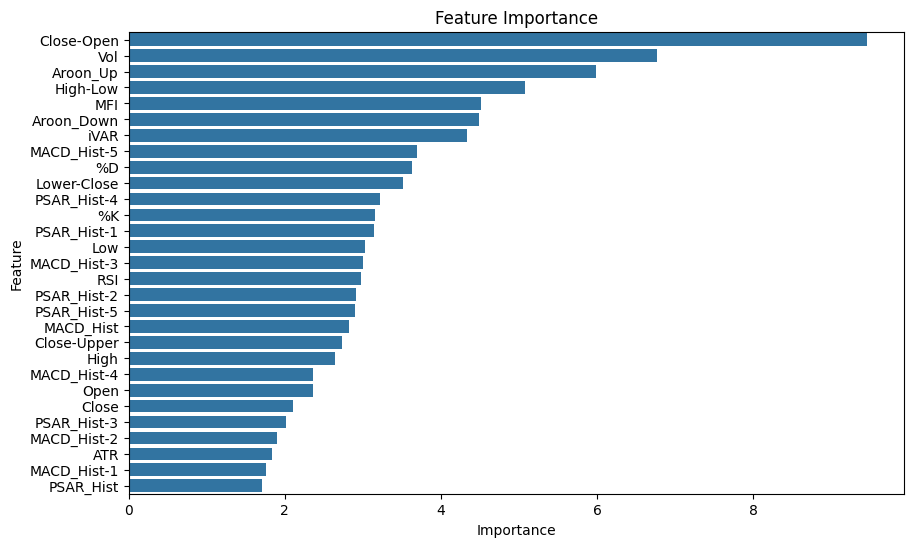

In [29]:
import seaborn as sns

# Визуализация важности признаков с помощью Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()

In [38]:
df_test.to_csv('demo.csv')

In [48]:
def calculate_all_indicators(data):
    df = data.copy()
    df = calculate_rsi(df)
    df = calculate_aroon(df)
    df = calculate_atr(df)
    df = calculate_bollinger_bands(df)
    df = calculate_ivar(df)
    df = calculate_macd(df)
    df = calculate_parabolic_sar(df)
    df = calculate_stochastic(df)
    df = calculate_mfi(df)

    df['Close-Upper'] = df['Close'] - df['Upper Band']
    df['Lower-Close'] = df['Lower Band'] - df['Close']
    df['MACD_Hist'] = df['MACD'] - df['MACD_Signal']
    df['PSAR_Hist'] = df['Close'] - df['Parabolic_SAR']

    df['Close-Open'] = df['Close'] - df['Open']
    df['High-Low'] = df['High'] - df['Low']

    for i in range(1, 6):
        df[f'PSAR_Hist-{i}'] = df['PSAR_Hist'].shift(i)
        df[f'MACD_Hist-{i}'] = df['MACD_Hist'].shift(i)

    df = df.dropna()
    cols = ['Open', 'High', 'Low', 'Close', 'Vol', 'RSI',
       'Aroon_Up', 'Aroon_Down', 'ATR', 'Date',
       'iVAR', '%K', 'Close-Open', 'High-Low',
       '%D', 'MFI', 'Close-Upper', 'Lower-Close', 'MACD_Hist', 'PSAR_Hist',
       'PSAR_Hist-1', 'MACD_Hist-1', 'PSAR_Hist-2', 'MACD_Hist-2',
       'PSAR_Hist-3', 'MACD_Hist-3', 'PSAR_Hist-4', 'MACD_Hist-4',
       'PSAR_Hist-5', 'MACD_Hist-5']

    df = df[cols]
    return df

In [54]:
buy = 0.51893268
sell = 0.47883711
data = pd.read_csv('data/GAZP_161221_241221.csv', delimiter=';')
data.columns = ['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Vol']
data_indicators = calculate_all_indicators(data)
data_preds = model.predict_proba(data_indicators.drop(columns=['Date']))[:, 1]
data_indicators['Buy'] = data_preds > buy
data_indicators['Sell'] = data_preds < sell
data_2024 = data_indicators[data_indicators['Date'] > 240000]
data_2024['Date'] = pd.to_datetime(data_2024['Date'], format='%y%m%d')


C:\Users\kitub\AppData\Local\Temp\ipykernel_11668\3955722793.py:17: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['Negative Money Flow'].iloc[i] = data['Money Flow'].iloc[i]
C:\Users\kitub\AppData\Local\Temp\ipykernel_11668\3955722793.p

In [55]:
data_2024

,Open,High,Low,Close,Vol,RSI,Aroon_Up,Aroon_Down,ATR,Date,...,PSAR_Hist-2,MACD_Hist-2,PSAR_Hist-3,MACD_Hist-3,PSAR_Hist-4,MACD_Hist-4,PSAR_Hist-5,MACD_Hist-5,Buy,Sell
1759,159.73,161.58,159.73,161.44,8080170,47.660550,71.428571,21.428571,2.458571,2024-01-03,...,-9.064044,-0.253892,-8.693796,-0.150019,-7.720200,-0.032426,-7.800000,0.053915,False,True
1760,161.51,161.64,161.00,161.25,4859980,43.497321,78.571429,28.571429,2.312857,2024-01-04,...,-8.085002,-0.272941,-9.064044,-0.253892,-8.693796,-0.150019,-7.720200,-0.032426,False,True
1761,161.22,162.30,161.07,161.94,8773230,52.886201,85.714286,35.714286,2.118571,2024-01-05,...,-5.601901,-0.138925,-8.085002,-0.272941,-9.064044,-0.253892,-8.693796,-0.150019,False,True
1762,162.43,163.20,162.00,163.05,11120640,46.404003,92.857143,42.857143,1.956429,2024-01-08,...,-5.262587,-0.050334,-5.601901,-0.138925,-8.085002,-0.272941,-9.064044,-0.253892,False,True
1763,163.01,163.06,161.77,162.41,9592690,33.405640,100.000000,50.000000,1.825714,2024-01-09,...,-4.075032,0.061415,-5.262587,-0.050334,-5.601901,-0.138925,-8.085002,-0.272941,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2003,112.68,112.80,108.11,108.71,78081350,41.251133,78.571429,7.142857,3.960000,2024-12-16,...,-11.153814,-0.442071,-9.323484,-0.411215,-10.017840,-0.489879,-7.896980,-0.481612,False,False
2004,108.75,109.47,106.10,107.26,67614540,29.497131,85.714286,7.142857,3.667143,2024-12-17,...,-11.168738,-0.422799,-11.153814,-0.442071,-9.323484,-0.411215,-10.017840,-0.489879,True,False
2005,107.45,108.57,105.22,108.05,79044430,29.282329,92.857143,7.142857,3.674286,2024-12-18,...,-14.855988,-0.621681,-11.168738,-0.422799,-11.153814,-0.442071,-9.323484,-0.411215,False,False
2006,108.05,111.16,106.00,107.16,164355270,17.593644,100.000000,14.285714,3.664286,2024-12-19,...,-15.378629,-0.773148,-14.855988,-0.621681,-11.168738,-0.422799,-11.153814,-0.442071,False,False


In [62]:
import pandas as pd
import matplotlib.pyplot as plt
from io import BytesIO

def demo_step(row, capital, position, data, buy_signals, sell_signals):
    if row['Buy'] and position == 0:
        entry_price = row['Close']
        shares_to_buy = capital // entry_price  # Целое количество акций
        new_position = shares_to_buy
        new_capital = capital - shares_to_buy * entry_price
        buy_signals.append((row['Date'], entry_price))
        df = data[data['Date'] <= row['Date']]
        plt.plot(df['Date'], df['Close'], label='Цена', color='blue')
        for buy_date, price in buy_signals:
            plt.scatter(buy_date, price, marker='^', color='green', label='Покупка', s=100)
        for sell_date, price in sell_signals:
            plt.scatter(sell_date, price, marker='v', color='red', label='Продажа', s=100)
        plt.xlabel('Дата')
        plt.ylabel('Цена')
        plt.legend()
        plt.grid()

        buf = BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)  # Перемещаем указатель в начало буфера
        plt.close()  # Закрываем фигуру после сохранения

        return 'Buy', new_capital, new_position, buf
    
    elif row['Sell'] and position > 0:
        new_capital = capital + position * row['Close']

        sell_signals.append((row['Date'], row['Close']))

        df = data[data['Date'] <= row['Date']]
        plt.plot(df['Date'], df['Close'], label='Цена', color='blue')
        for buy_date, price in buy_signals:
            plt.scatter(buy_date, price, marker='^', color='green', label='Покупка', s=100)
        for sell_date, price in sell_signals:
            plt.scatter(sell_date, price, marker='v', color='red', label='Продажа', s=100)
        plt.xlabel('Дата')
        plt.ylabel('Цена')
        plt.legend()
        plt.grid()

        buf = BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)  # Перемещаем указатель в начало буфера
        plt.close()  # Закрываем фигуру после сохранения

        return 'Sell', new_capital, 0, buf
    else:
        return 'nothing', capital, position, None

In [68]:
capital = 100_000
position = 0
buy_signals = []
sell_signals = []
photos = []


for i, row in data_2024.iterrows():
        if i == 1759:
            first_close = row['Close']
        #await bot.send_message(user_id, f"Запущен демо-режим на данных 2024 года, начальный капитал 100000 рублей")
        old_pos = position
        signal, capital, position, buf = demo_step(row, capital, position, data_2024, buy_signals, sell_signals)

        if signal == 'Buy':
            print(f"Куплено {position} акций по цене {row['Close']:.2f} руб. Остаток на счете {capital:.2f} руб.")
            photos.append(buf)
        elif signal == 'Sell':
            print(f"Продано {old_pos} акций по цене {row['Close']:.2f} руб. На счете {capital:.2f} руб.")
            photos.append(buf)
        last_close = row['Close']

buy_n_hold = (100000 // first_close) * last_close + 100000 % first_close
if position > 0:
    capital = capital + position*last_close


Куплено 612.0 акций по цене 163.33 руб. Остаток на счете 42.04 руб.
Продано 612.0 акций по цене 162.86 руб. На счете 99712.36 руб.
Куплено 638.0 акций по цене 156.16 руб. Остаток на счете 82.28 руб.
Продано 638.0 акций по цене 155.17 руб. На счете 99080.74 руб.
Куплено 711.0 акций по цене 139.25 руб. Остаток на счете 73.99 руб.
Продано 711.0 акций по цене 124.93 руб. На счете 88899.22 руб.
Куплено 731.0 акций по цене 121.54 руб. Остаток на счете 53.48 руб.
Продано 731.0 акций по цене 118.02 руб. На счете 86326.10 руб.
Куплено 744.0 акций по цене 115.92 руб. Остаток на счете 81.62 руб.
Продано 744.0 акций по цене 126.20 руб. На счете 93974.42 руб.
Куплено 769.0 акций по цене 122.17 руб. Остаток на счете 25.69 руб.
Продано 769.0 акций по цене 127.74 руб. На счете 98257.75 руб.
Куплено 834.0 акций по цене 117.81 руб. Остаток на счете 4.21 руб.
Продано 834.0 акций по цене 119.28 руб. На счете 99483.73 руб.
Куплено 759.0 акций по цене 130.99 руб. Остаток на счете 62.32 руб.
Продано 759.0 ак

In [70]:
import logging
import os

from pandas import DataFrame

from tinkoff.invest import Client, SecurityTradingStatus
from tinkoff.invest.services import InstrumentsService
from tinkoff.invest.utils import quotation_to_decimal

TOKEN = "t.wjnuWsY82HsHfGHSWJA7n8rAx66AOrLMHeV_DjiBD9ZQ0ALrPpljPxsx3fpZgQYwyuyO77Nckl5Mb2f3aOm0sA"

logging.basicConfig(format="%(asctime)s %(levelname)s:%(message)s", level=logging.DEBUG)
logger = logging.getLogger(__name__)



"""Example - How to get figi by name of ticker."""

ticker = "GAZP"  # "BRH3" "SBER" "VTBR"

with Client(TOKEN) as client:
    instruments: InstrumentsService = client.instruments
    tickers = []
    for method in ["shares", "bonds", "etfs", "currencies", "futures"]:
        for item in getattr(instruments, method)().instruments:
            tickers.append(
                {
                    "name": item.name,
                    "ticker": item.ticker,
                    "class_code": item.class_code,
                    "figi": item.figi,
                    "uid": item.uid,
                    "type": method,
                    "min_price_increment": quotation_to_decimal(
                        item.min_price_increment
                    ),
                    "scale": 9 - len(str(item.min_price_increment.nano)) + 1,
                    "lot": item.lot,
                    "trading_status": str(
                        SecurityTradingStatus(item.trading_status).name
                    ),
                    "api_trade_available_flag": item.api_trade_available_flag,
                    "currency": item.currency,
                    "exchange": item.exchange,
                    "buy_available_flag": item.buy_available_flag,
                    "sell_available_flag": item.sell_available_flag,
                    "short_enabled_flag": item.short_enabled_flag,
                    "klong": quotation_to_decimal(item.klong),
                    "kshort": quotation_to_decimal(item.kshort),
                }
            )

    tickers_df = DataFrame(tickers)

    ticker_df = tickers_df[tickers_df["ticker"] == ticker]
    if ticker_df.empty:
        logger.error("There is no such ticker: %s", ticker)


    figi = ticker_df["figi"].iloc[0]
    print(f"\nTicker {ticker} have figi={figi}\n")
    print(f"Additional info for this {ticker} ticker:")
    print(ticker_df.iloc[0])


2024-12-23 06:53:51,567 INFO:423df9f7513444e4ac03dd29b958f970 Shares
2024-12-23 06:53:52,545 INFO:117d553c769db344bb8a83916d7926fa Bonds
2024-12-23 06:53:53,070 INFO:a9d2127ecbd0a2f02e409e0f46b94b05 Etfs
2024-12-23 06:53:53,183 INFO:012f84d705d825488861d61879a66e03 Currencies
2024-12-23 06:53:53,228 INFO:46f3a72f2084767cde8475fdbea3cf1f Futures



Ticker GAZP have figi=BBG004730RP0

Additional info for this GAZP ticker:
name                                                                  Газпром
ticker                                                                   GAZP
class_code                                                               TQBR
figi                                                             BBG004730RP0
uid                                      962e2a95-02a9-4171-abd7-aa198dbe643a
type                                                                   shares
min_price_increment                                                0.01000000
scale                                                                       2
lot                                                                        10
trading_status              SECURITY_TRADING_STATUS_NOT_AVAILABLE_FOR_TRADING
api_trade_available_flag                                                 True
currency                                                           

In [ ]:
import os
from datetime import timedelta

from tinkoff.invest import CandleInterval, Client
from tinkoff.invest.utils import now

def units_nano_to_num(candle_arg):
    return candle_arg.units + candle_arg.nano / 1000000000

d = {
    'Date': [],
    'Open': [],
    'High': [],
    'Low': [],
    'Close': [],
    'Vol': []
}
with Client(TOKEN) as client:
    for candle in client.get_all_candles(
        figi="BBG004730RP0",
        from_=now() - timedelta(days=100),
        interval=CandleInterval.CANDLE_INTERVAL_DAY,
    ):
        d['Date'].append(candle.time)
        d['Open'].append(units_nano_to_num(candle.open))
        d['High'].append(units_nano_to_num(candle.high))
        d['Low'].append(units_nano_to_num(candle.low))
        d['Close'].append(units_nano_to_num(candle.close))
        d['Vol'].append(candle.volume*10)
df = pd.DataFrame.from_dict(d)
df

2024-12-23 07:06:34,423 INFO:bebb08f467712dab6c5435329c518b72 GetCandles


,Date,Open,High,Low,Close,Vol
0,2024-09-16 00:00:00+00:00,120.60,122.62,119.52,121.73,38854810
1,2024-09-17 00:00:00+00:00,121.91,123.47,120.17,123.10,36877510
2,2024-09-18 00:00:00+00:00,122.53,123.90,121.90,122.18,30649560
3,2024-09-19 00:00:00+00:00,121.90,123.39,121.21,122.24,43382140
4,2024-09-20 00:00:00+00:00,122.30,123.18,121.86,122.40,28518020
...,...,...,...,...,...,...
65,2024-12-16 00:00:00+00:00,112.69,112.80,108.11,108.71,78161020
66,2024-12-17 00:00:00+00:00,108.72,109.47,106.10,107.26,67650770
67,2024-12-18 00:00:00+00:00,107.46,108.57,105.22,108.05,79060770
68,2024-12-19 00:00:00+00:00,108.00,111.16,106.00,107.16,164458790
